In [ ]:
!pip install transformers
!pip install torchvision
import os
import math

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 778kB 5.3MB/s 
     |████████████████████████████████| 1.1MB 29.8MB/s 
     |████████████████████████████████| 890kB 38.3MB/s 
     |████████████████████████████████| 3.0MB 50.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=5633e5ba84163c53004c968e4fefc29e317cdfdd5ec560f8eff9d21117a01535
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.72GB
Available: 11.76GB
Used: 716.11MB
Percentage: 7.6%


In [ ]:
! nvidia-smi

Wed Aug 12 06:16:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))

GPU Available: True
Number of GPU Available: 1
GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_pickle("/content/drive/My Drive/Data science/sent_annot.pkl")

In [ ]:
df.shape

(117915, 2)

In [ ]:

X_enc = pd.get_dummies(df, columns=['label'])
# mergedata = mergedata.drop(['sex','region','smoker'],axis=1)
X_enc

sentence  ...  label_ami_da_9
0       Hi , I'm David and I'm supposed to be an indus...  ...               0
1       Um , I just got the project announcement about...  ...               0
2                           Designing a remote control .   ...               0
3           That's about it , didn't get anything else .   ...               0
4                           Did you get the same thing ?   ...               0
...                                                   ...  ...             ...
117910                                        then we'll   ...               0
117911                            overall , two points .   ...               0
117912                                             Yes .   ...               0
117913                                            Yeah .   ...               0
117914                                              Mm .   ...               0

[117915 rows x 16 columns]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


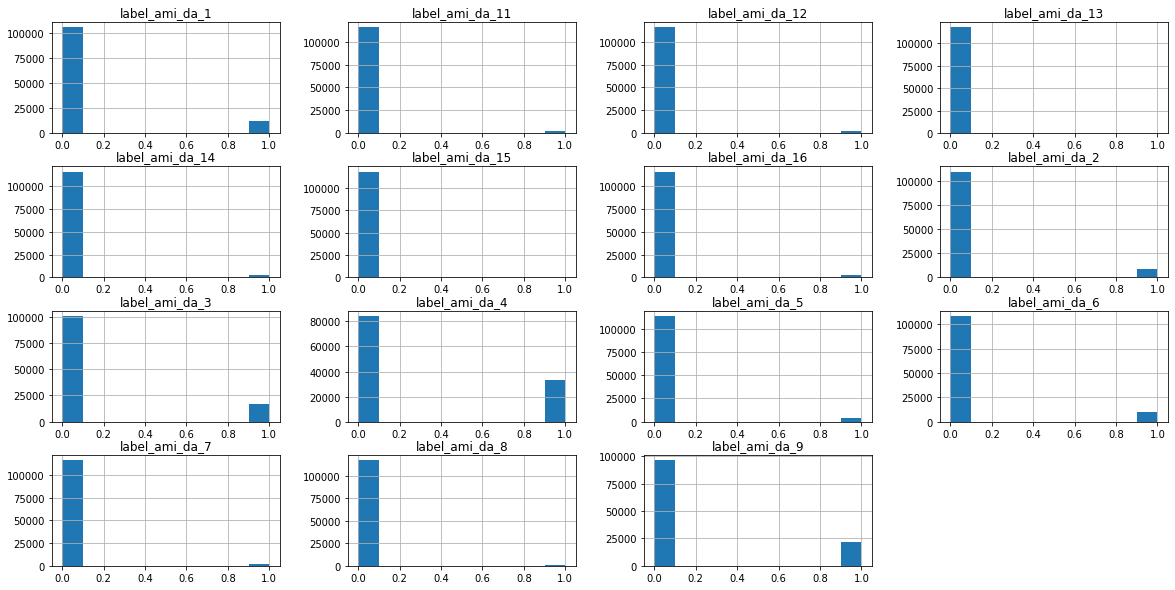

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10));
X_enc[["label_ami_da_1","label_ami_da_11","label_ami_da_12","label_ami_da_13","label_ami_da_14","label_ami_da_15","label_ami_da_16","label_ami_da_2","label_ami_da_3","label_ami_da_4","label_ami_da_5","label_ami_da_6","label_ami_da_7","label_ami_da_8","label_ami_da_9"]].hist(ax=ax);


In [ ]:
train, test = train_test_split(X_enc, test_size=0.2, random_state=42)

In [ ]:
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
train_text_list = train["sentence"].values
test_text_list = test["sentence"].values

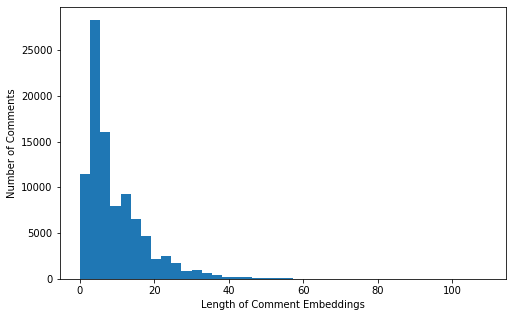

In [ ]:
plot_sentence_embeddings_length(train_text_list, tokenizer)

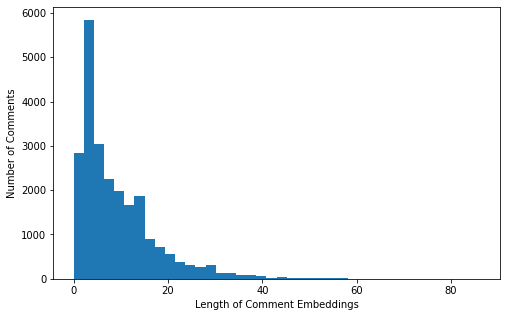

In [ ]:
plot_sentence_embeddings_length(test_text_list, tokenizer)

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=512):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [ ]:
# create input id tokens
train_input_ids = tokenize_inputs(train_text_list, tokenizer, num_embeddings=250)
train_input_ids

array([[  17, 1212,  145, ...,    0,    0,    0],
       [4968,   17,    9, ...,    0,    0,    0],
       [3466,   17,    9, ...,    0,    0,    0],
       ...,
       [  17, 1212,    4, ...,    0,    0,    0],
       [  63,   26,   88, ...,    0,    0,    0],
       [   4,    3,    0, ...,    0,    0,    0]])

In [ ]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=250)
test_input_ids

array([[   17,  1212,    57, ...,     0,     0,     0],
       [   17, 11156,   121, ...,     0,     0,     0],
       [  105,    44,   216, ...,     0,     0,     0],
       ...,
       [ 4968,    17,     9, ...,     0,     0,     0],
       [  113,   113,    41, ...,     0,     0,     0],
       [  102,    36,    17, ...,     0,     0,     0]])

In [ ]:
# create attention masks
train_attention_masks = create_attn_masks(train_input_ids)
train_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [ ]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
test_attention_masks

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,

In [ ]:
# add input ids and attention masks to the dataframe
train["features"] = train_input_ids.tolist()
train["masks"] = train_attention_masks

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
train.head()

sentence  ...                                              masks
102845  Um now the new project requirements , I'll jus...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
10772                                             Okay .   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
60362                                           Thanks .   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
51173                                         Yes okay .   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...
52367                   Wha what is this strange beast ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...

[5 rows x 18 columns]

In [ ]:
test1=test[["sentence","features","masks"]]
test1.head()

sentence  ...                                              masks
112212                                   Um but , well ,   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
13948               cou could you go back for a second ?   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
46277                                     there you go .   ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...
51197   because th th th the the selling price is alre...  ...  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...
44576                                            Between   ...  [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

[5 rows x 3 columns]

In [ ]:
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [ ]:
X_train = train["features"].values.tolist()
X_valid = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
valid_masks = valid["masks"].values.tolist()

label_cols = ["label_ami_da_1","label_ami_da_11","label_ami_da_12","label_ami_da_13","label_ami_da_14","label_ami_da_15","label_ami_da_16","label_ami_da_2","label_ami_da_3","label_ami_da_4","label_ami_da_5","label_ami_da_6","label_ami_da_7","label_ami_da_8","label_ami_da_9"]
Y_train = train[label_cols].values.tolist()
Y_valid = valid[label_cols].values.tolist()

In [ ]:
# Convert all of our input ids and attention masks into 
# torch tensors, the required datatype for our model

X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_valid = torch.tensor(Y_valid, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype=torch.long)
valid_masks = torch.tensor(valid_masks, dtype=torch.long)

In [ ]:
# Select a batch size for training
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on 
# memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(X_train, train_masks, Y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,\
                              sampler=train_sampler,\
                              batch_size=batch_size)

validation_data = TensorDataset(X_valid, valid_masks, Y_valid)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,\
                                   sampler=validation_sampler,\
                                   batch_size=batch_size)

In [ ]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
    """
    Train the model and save the model with the lowest validation loss
    """
    model.to(device)

  # trange is a tqdm wrapper around the normal python range
    for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
        actual_epoch = start_epoch + i

    # Training

    # Set our model to training mode (as opposed to evaluation mode)
        model.train()

    # Tracking variables
        tr_loss = 0
        num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
      # Forward pass
        loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
      # store train loss
        tr_loss += loss.item()
        num_train_samples += b_labels.size(0)
      # Backward pass
        loss.backward()
      # Update parameters and take a step using the computed gradient
        optimizer.step()
      #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

    print("Train loss: {}".format(epoch_train_loss))

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients,
      # saving memory and speeding up validation
        with torch.no_grad():
        # Forward pass, calculate validation loss
            loss = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store valid loss
            eval_loss += loss.item()
            num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    print("Valid loss: {}".format(epoch_eval_loss))

    if lowest_eval_loss == None:
        lowest_eval_loss = epoch_eval_loss
      # save model
        save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
        if epoch_eval_loss < lowest_eval_loss:
            lowest_eval_loss = epoch_eval_loss
        # save model
            save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
    print("\n")

    return model, train_loss_set, valid_loss_set


def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
    """
    Save the model to the path directory provided
    """
    model_to_save = model.module if hasattr(model, 'module') else model
    checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
    torch.save(checkpoint, save_path)
    print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
    return
  
def load_model(save_path):
    """
    Load the model from the path directory provided
    """
    checkpoint = torch.load(save_path)
    model_state_dict = checkpoint['state_dict']
    model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
    model.load_state_dict(model_state_dict)

    epochs = checkpoint["epochs"]
    lowest_eval_loss = checkpoint["lowest_eval_loss"]
    train_loss_hist = checkpoint["train_loss_hist"]
    valid_loss_hist = checkpoint["valid_loss_hist"]
  
    return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels=2):
        super(XLNetForMultiLabelSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        self.classifier = torch.nn.Linear(768, num_labels)

        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
    # last hidden layer
        last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids)
    # pool the outputs into a mean vector
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
        logits = self.classifier(mean_last_hidden_state)
        
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels),\
                      labels.view(-1, self.num_labels))
            return loss
        else:
            return logits
    
    def freeze_xlnet_decoder(self):
        """
        Freeze XLNet weight parameters. They will not be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = False
    
    def unfreeze_xlnet_decoder(self):
        """
        Unfreeze XLNet weight parameters. They will be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = True
    
    def pool_hidden_state(self, last_hidden_state):
        """
        Pool the output vectors into a single mean vector 
        """
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(Y_train[0]))
#model = torch.nn.DataParallel(model)
#model.cuda()

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [ ]:
num_epochs=3

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/My Drive/xlnet_toxic.bin")
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              device="cuda")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.007284295266839829
Valid loss: 0.006686323051997251


Epoch:  33%|███▎      | 1/3 [3:00:46<6:01:33, 10846.98s/it]

Saving model at epoch 0 with validation loss of 0.006686323051997251


Train loss: 0.006305480631791415
Valid loss: 0.006407813520720696


Epoch:  67%|██████▋   | 2/3 [6:00:51<3:00:34, 10834.24s/it]

Saving model at epoch 1 with validation loss of 0.006407813520720696


Train loss: 0.005790132059037729


Epoch: 100%|██████████| 3/3 [9:00:45<00:00, 10815.22s/it]

Valid loss: 0.00666538210412056




Text(0.5, 1.0, 'Loss vs Number of Epochs')

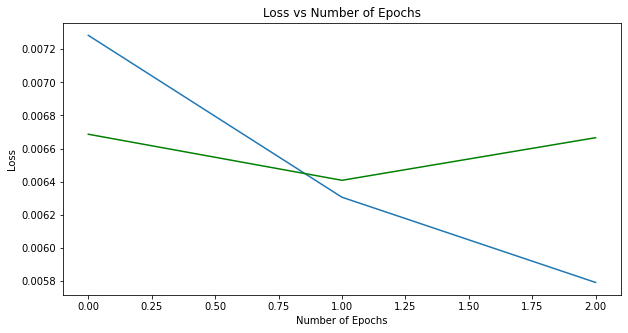

In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")

In [ ]:
cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/content/drive/My Drive/xlnet_toxic.bin")
model, start_epoch, lowest_eval_loss, train_loss_hist, valid_loss_hist = load_model(model_save_path)

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01, correct_bias=False)

In [ ]:
num_epochs=6
model, train_loss_set, valid_loss_set = train(model=model,\
                                              num_epochs=num_epochs,\
                                              optimizer=optimizer,\
                                              train_dataloader=train_dataloader,\
                                              valid_dataloader=validation_dataloader,\
                                              model_save_path=model_save_path,\
                                              train_loss_set=train_loss_hist,\
                                              valid_loss_set=valid_loss_hist,\
                                              lowest_eval_loss=lowest_eval_loss,\
                                              start_epoch=start_epoch,\
                                              device="cuda")

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Train loss: 0.006004947891021623


Epoch:  17%|█▋        | 1/6 [1:46:44<8:53:44, 6404.88s/it]

Valid loss: 0.006470546820155813


Train loss: 0.005272091184183388


Epoch:  33%|███▎      | 2/6 [3:33:33<7:07:03, 6405.92s/it]

Valid loss: 0.006859211905526164


Train loss: 0.004785091008709379


Epoch:  50%|█████     | 3/6 [5:20:24<5:20:22, 6407.57s/it]

Valid loss: 0.007114582705210926


Train loss: 0.004349953885377342


Epoch:  67%|██████▋   | 4/6 [7:07:17<3:33:38, 6409.30s/it]

Valid loss: 0.008002171503925792


Train loss: 0.004054383968444844


Epoch:  83%|████████▎ | 5/6 [8:54:11<1:46:50, 6410.64s/it]

Valid loss: 0.008248511797696626




In [ ]:
# Plot loss
num_epochs = np.arange(len(train_loss_set))

fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(train_loss_set), label="Train Loss")
ax.plot(num_epochs, np.array(valid_loss_set), 'g-', label="Valid Loss")
#ax1.plot(episode_record, lose_record, 'r-', label="Lose %")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Number of Epochs")